In [1]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
# matplotlib.use("Agg")

# import the necessary packages
import time
import pandas as pd
import seaborn as sn
import keras
import os
import cv2
import pickle
import random
import argparse
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.layers import Dense
from keras.preprocessing.image import img_to_array
from keras.models import Model
from keras.optimizers import Adam
from keras.optimizers import Nadam
from keras.optimizers import RMSprop
from keras.losses import logcosh, binary_crossentropy
from keras.activations import relu, elu, sigmoid
from keras.preprocessing.image import ImageDataGenerator
# import matplotlib
# matplotlib.use("Agg")

Using TensorFlow backend.


In [2]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 300
INIT_LR = 1e-2
BS = 32
IMAGE_DIMS = (224, 224, 3)

In [3]:
from imutils import paths

imagePaths = sorted(list(paths.list_images("anger_classification")))
random.seed(42)
random.shuffle(imagePaths)
imagePaths

['anger_classification\\non_anger\\non_anger_143.jpg',
 'anger_classification\\non_anger\\non_anger_888.jpg',
 'anger_classification\\non_anger\\non_anger_737.jpg',
 'anger_classification\\non_anger\\non_anger_161.jpg',
 'anger_classification\\non_anger\\non_anger_2171.jpg',
 'anger_classification\\non_anger\\non_anger_1294.jpg',
 'anger_classification\\non_anger\\non_anger_1630.jpg',
 'anger_classification\\non_anger\\non_anger_427.jpg',
 'anger_classification\\non_anger\\non_anger_1039.jpg',
 'anger_classification\\non_anger\\non_anger_1054.jpg',
 'anger_classification\\non_anger\\non_anger_1827.jpg',
 'anger_classification\\non_anger\\non_anger_1946.jpg',
 'anger_classification\\non_anger\\non_anger_551.jpg',
 'anger_classification\\anger\\anger_444.jpg',
 'anger_classification\\non_anger\\non_anger_558.jpg',
 'anger_classification\\anger\\anger_459.jpg',
 'anger_classification\\non_anger\\non_anger_111.jpg',
 'anger_classification\\non_anger\\non_anger_632.jpg',
 'anger_classificat

In [4]:
from keras.preprocessing.image import img_to_array

data = []
labels = []

# loop over the input images
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)

    # extract the class label from the image path and update the
    # labels list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

In [5]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {:.2f}MB".format(
    data.nbytes / (1024 * 1000.0)))

[INFO] data matrix: 3542.11MB


In [6]:
from sklearn.preprocessing import LabelBinarizer

# binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [7]:
from sklearn.model_selection import train_test_split

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0.2, random_state=42)

In [8]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

In [9]:
# import the necessary packages
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import add
from keras.regularizers import l2
from keras import backend as K

class ResNet:
	@staticmethod
	def residual_module(data, K, stride, chanDim, red=False,
		reg=0.0001, bnEps=2e-5, bnMom=0.9):
		# the shortcut branch of the ResNet module should be
		# initialize as the input (identity) data
		shortcut = data

		# the first block of the ResNet module are the 1x1 CONVs
		bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(data)
		act1 = Activation("relu")(bn1)
		conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias=False,
			kernel_regularizer=l2(reg))(act1)

		# the second block of the ResNet module are the 3x3 CONVs
		bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(conv1)
		act2 = Activation("relu")(bn2)
		conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride,
			padding="same", use_bias=False,
			kernel_regularizer=l2(reg))(act2)

		# the third block of the ResNet module is another set of 1x1
		# CONVs
		bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(conv2)
		act3 = Activation("relu")(bn3)
		conv3 = Conv2D(K, (1, 1), use_bias=False,
			kernel_regularizer=l2(reg))(act3)

		# if we are to reduce the spatial size, apply a CONV layer to
		# the shortcut
		if red:
			shortcut = Conv2D(K, (1, 1), strides=stride,
				use_bias=False, kernel_regularizer=l2(reg))(act1)

		# add together the shortcut and the final CONV
		x = add([conv3, shortcut])

		# return the addition as the output of the ResNet module
		return x

	@staticmethod
	def build(width, height, depth, classes, stages, filters,
		reg=0.0001, bnEps=2e-5, bnMom=0.9):
		# initialize the input shape to be "channels last" and the
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# set the input and apply BN
		inputs = Input(shape=inputShape)
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(inputs)

		# apply CONV => BN => ACT => POOL to reduce spatial size
		x = Conv2D(filters[0], (5, 5), use_bias=False,
			padding="same", kernel_regularizer=l2(reg))(x)
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(x)
		x = Activation("relu")(x)
		x = ZeroPadding2D((1, 1))(x)
		x = MaxPooling2D((3, 3), strides=(2, 2))(x)

		# loop over the number of stages
		for i in range(0, len(stages)):
			# initialize the stride, then apply a residual module
			# used to reduce the spatial size of the input volume
			stride = (1, 1) if i == 0 else (2, 2)
			x = ResNet.residual_module(x, filters[i + 1], stride,
				chanDim, red=True, bnEps=bnEps, bnMom=bnMom)

			# loop over the number of layers in the stage
			for j in range(0, stages[i] - 1):
				# apply a ResNet module
				x = ResNet.residual_module(x, filters[i + 1],
					(1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)

		# apply BN => ACT => POOL
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(x)
		x = Activation("relu")(x)
		x = AveragePooling2D((8, 8))(x)

		# softmax classifier
		x = Flatten()(x)
		x = Dense(classes, kernel_regularizer=l2(reg))(x)
		x = Activation("softmax")(x)

		# create the model
		model = Model(inputs, x, name="resnet")

		# return the constructed network architecture
		return model

In [10]:
from keras.optimizers import SGD

print("[INFO] compiling model...")
model = ResNet.build(224, 224, 3, 2, (2, 3, 4), (32, 64, 128, 256), reg=0.0001)
opt = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR/EPOCHS)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])
print("[INFO] done compiling.")

model.summary()

[INFO] compiling model...
[INFO] done compiling.
Model: "resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 2400        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 224, 224, 32) 128         conv2d_1[0][0]                   
____________________________________________

In [11]:
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [12]:
# train the network
print("[INFO] training network...")
H = model.fit_generator(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS, verbose=1)#, class_weight={0:3, 1:1})

# save the model to disk
print("[INFO] serializing network...")
model.save("anger_imbalanced.model")

[INFO] training network...
Epoch 1/300
75/75 [==============================] - 30s 406ms/step - loss: 0.9305 - accuracy: 0.6887 - val_loss: 1.0249 - val_accuracy: 0.7280
Epoch 2/300
75/75 [==============================] - 21s 284ms/step - loss: 0.8518 - accuracy: 0.6975 - val_loss: 1.3491 - val_accuracy: 0.7280
Epoch 3/300
75/75 [==============================] - 21s 284ms/step - loss: 0.8318 - accuracy: 0.7009 - val_loss: 0.7493 - val_accuracy: 0.7297
Epoch 4/300
75/75 [==============================] - 21s 285ms/step - loss: 0.8245 - accuracy: 0.7093 - val_loss: 0.7448 - val_accuracy: 0.7114
Epoch 5/300
75/75 [==============================] - 21s 285ms/step - loss: 0.7581 - accuracy: 0.7354 - val_loss: 0.9163 - val_accuracy: 0.7264
Epoch 6/300
75/75 [==============================] - 21s 285ms/step - loss: 0.7286 - accuracy: 0.7493 - val_loss: 0.7507 - val_accuracy: 0.7231
Epoch 7/300
75/75 [==============================] - 21s 284ms/step - loss: 0.7194 - accuracy: 0.7438 - val_l

75/75 [==============================] - 21s 284ms/step - loss: 0.6435 - accuracy: 0.7791 - val_loss: 0.6940 - val_accuracy: 0.7280
Epoch 58/300
75/75 [==============================] - 21s 281ms/step - loss: 0.6351 - accuracy: 0.7732 - val_loss: 0.7183 - val_accuracy: 0.7114
Epoch 59/300
75/75 [==============================] - 21s 286ms/step - loss: 0.6347 - accuracy: 0.7713 - val_loss: 0.6723 - val_accuracy: 0.7479
Epoch 60/300
75/75 [==============================] - 21s 284ms/step - loss: 0.6313 - accuracy: 0.7741 - val_loss: 0.6608 - val_accuracy: 0.7463
Epoch 61/300
75/75 [==============================] - 21s 283ms/step - loss: 0.6311 - accuracy: 0.7850 - val_loss: 0.6755 - val_accuracy: 0.7280
Epoch 62/300
75/75 [==============================] - 21s 283ms/step - loss: 0.6314 - accuracy: 0.7753 - val_loss: 0.6892 - val_accuracy: 0.7347
Epoch 63/300
75/75 [==============================] - 21s 283ms/step - loss: 0.6291 - accuracy: 0.7703 - val_loss: 0.6946 - val_accuracy: 0.752

75/75 [==============================] - 21s 283ms/step - loss: 0.5598 - accuracy: 0.8166 - val_loss: 0.7028 - val_accuracy: 0.7446
Epoch 114/300
75/75 [==============================] - 21s 286ms/step - loss: 0.5486 - accuracy: 0.8200 - val_loss: 0.7977 - val_accuracy: 0.7430
Epoch 115/300
75/75 [==============================] - 21s 281ms/step - loss: 0.5311 - accuracy: 0.8335 - val_loss: 0.7144 - val_accuracy: 0.7280
Epoch 116/300
75/75 [==============================] - 21s 286ms/step - loss: 0.5633 - accuracy: 0.8112 - val_loss: 0.7371 - val_accuracy: 0.7297
Epoch 117/300
75/75 [==============================] - 21s 286ms/step - loss: 0.5501 - accuracy: 0.8254 - val_loss: 0.6896 - val_accuracy: 0.7313
Epoch 118/300
75/75 [==============================] - 21s 283ms/step - loss: 0.5538 - accuracy: 0.8098 - val_loss: 0.6794 - val_accuracy: 0.7562
Epoch 119/300
75/75 [==============================] - 21s 283ms/step - loss: 0.5373 - accuracy: 0.8233 - val_loss: 0.6977 - val_accuracy:

75/75 [==============================] - 21s 286ms/step - loss: 0.4585 - accuracy: 0.8637 - val_loss: 0.7840 - val_accuracy: 0.7446
Epoch 170/300
75/75 [==============================] - 21s 281ms/step - loss: 0.4733 - accuracy: 0.8551 - val_loss: 0.8492 - val_accuracy: 0.7396
Epoch 171/300
75/75 [==============================] - 21s 283ms/step - loss: 0.4624 - accuracy: 0.8599 - val_loss: 0.7819 - val_accuracy: 0.7380
Epoch 172/300
75/75 [==============================] - 21s 283ms/step - loss: 0.4445 - accuracy: 0.8675 - val_loss: 0.8442 - val_accuracy: 0.7264
Epoch 173/300
75/75 [==============================] - 21s 283ms/step - loss: 0.4605 - accuracy: 0.8603 - val_loss: 0.8429 - val_accuracy: 0.7380
Epoch 174/300
75/75 [==============================] - 21s 283ms/step - loss: 0.4632 - accuracy: 0.8603 - val_loss: 0.7737 - val_accuracy: 0.7280
Epoch 175/300
75/75 [==============================] - 21s 283ms/step - loss: 0.4298 - accuracy: 0.8767 - val_loss: 0.7942 - val_accuracy:

75/75 [==============================] - 21s 286ms/step - loss: 0.4237 - accuracy: 0.8772 - val_loss: 0.8625 - val_accuracy: 0.7197
Epoch 226/300
75/75 [==============================] - 22s 287ms/step - loss: 0.4045 - accuracy: 0.8809 - val_loss: 0.9475 - val_accuracy: 0.6949
Epoch 227/300
75/75 [==============================] - 21s 286ms/step - loss: 0.4175 - accuracy: 0.8729 - val_loss: 0.8963 - val_accuracy: 0.7612
Epoch 228/300
75/75 [==============================] - 21s 286ms/step - loss: 0.4138 - accuracy: 0.8809 - val_loss: 0.8823 - val_accuracy: 0.7197
Epoch 229/300
75/75 [==============================] - 21s 285ms/step - loss: 0.3991 - accuracy: 0.8877 - val_loss: 0.9708 - val_accuracy: 0.7048
Epoch 230/300
75/75 [==============================] - 21s 286ms/step - loss: 0.4110 - accuracy: 0.8847 - val_loss: 0.8481 - val_accuracy: 0.7413
Epoch 231/300
75/75 [==============================] - 21s 285ms/step - loss: 0.4074 - accuracy: 0.8864 - val_loss: 0.8504 - val_accuracy:

75/75 [==============================] - 21s 286ms/step - loss: 0.3634 - accuracy: 0.9025 - val_loss: 0.9054 - val_accuracy: 0.7512
Epoch 282/300
75/75 [==============================] - 21s 284ms/step - loss: 0.3490 - accuracy: 0.9154 - val_loss: 0.9113 - val_accuracy: 0.7380
Epoch 283/300
75/75 [==============================] - 21s 284ms/step - loss: 0.3816 - accuracy: 0.8944 - val_loss: 0.9438 - val_accuracy: 0.7413
Epoch 284/300
75/75 [==============================] - 21s 284ms/step - loss: 0.3623 - accuracy: 0.9053 - val_loss: 0.9216 - val_accuracy: 0.7496
Epoch 285/300
75/75 [==============================] - 21s 284ms/step - loss: 0.3500 - accuracy: 0.9079 - val_loss: 0.9055 - val_accuracy: 0.7662
Epoch 286/300
75/75 [==============================] - 21s 284ms/step - loss: 0.3705 - accuracy: 0.8885 - val_loss: 1.0324 - val_accuracy: 0.7529
Epoch 287/300
75/75 [==============================] - 21s 281ms/step - loss: 0.3507 - accuracy: 0.9057 - val_loss: 0.9000 - val_accuracy:

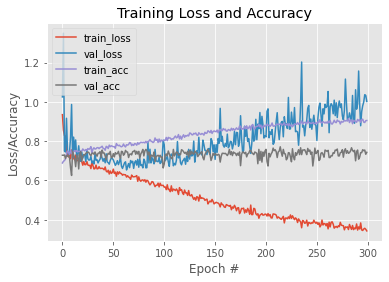

<Figure size 432x288 with 0 Axes>

In [13]:
plt.style.use("ggplot")
%matplotlib inline
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.show()
plt.savefig("anger_class_weights_plot_imbalanced.png")

In [14]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
 

# predict probabilities for test set
yhat_probs = model.predict(testX, verbose=0)
# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs, axis=1)

Classification report: 
---------------------------------------------------------- 
              precision    recall  f1-score   support

       anger       0.53      0.46      0.50       164
   non-anger       0.81      0.85      0.83       439

    accuracy                           0.74       603
   macro avg       0.67      0.66      0.66       603
weighted avg       0.73      0.74      0.74       603

---------------------------------------------------------- 
Accuracy score: 0.742952
Precision score: 0.808696
Recall score: 0.847380
F1 score: 0.827586
---------------------------------------------------------- 
Confusion matrix: 
[[ 76  88]
 [ 67 372]]


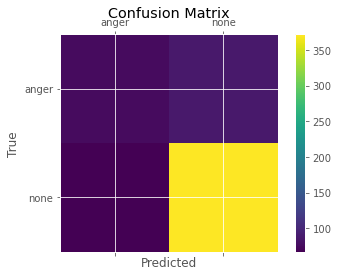

[[ 76  88]
 [ 67 372]]


In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

classif_report = classification_report(testY, yhat_classes, target_names=['anger', 'non-anger'])
print('Classification report: ')
print('---------------------------------------------------------- ')
print(classif_report)

print('---------------------------------------------------------- ')
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testY, yhat_classes)
print('Accuracy score: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testY, yhat_classes)
print('Precision score: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testY, yhat_classes)
print('Recall score: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testY, yhat_classes)
print('F1 score: %f' % f1)
print('---------------------------------------------------------- ')

# confusion matrix
labels = ['anger', 'none']
matrix = confusion_matrix(testY, yhat_classes)
print('Confusion matrix: ')
print(matrix)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrix)
plt.title('Confusion Matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix_anger_imbalanced.png')
plt.show()
print(matrix)